![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/enterprise/healthcare/3.Clinical_Entity_Resolvers.ipynb)

In [ ]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

In [ ]:
%%capture
for k,v in license_keys.items(): 
    %set_env $k=$v

!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jsl_colab_setup.sh
!bash jsl_colab_setup.sh

! pip install spark-nlp-display

In [ ]:
import json
import os
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
from sparknlp.util import *
import sparknlp_jsl
import sparknlp

from sparknlp.pretrained import ResourceDownloader
from pyspark.sql import functions as F

params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 3.1.0
Spark NLP_JSL Version : 3.1.1


In [ ]:
spark

# Clinical Resolvers

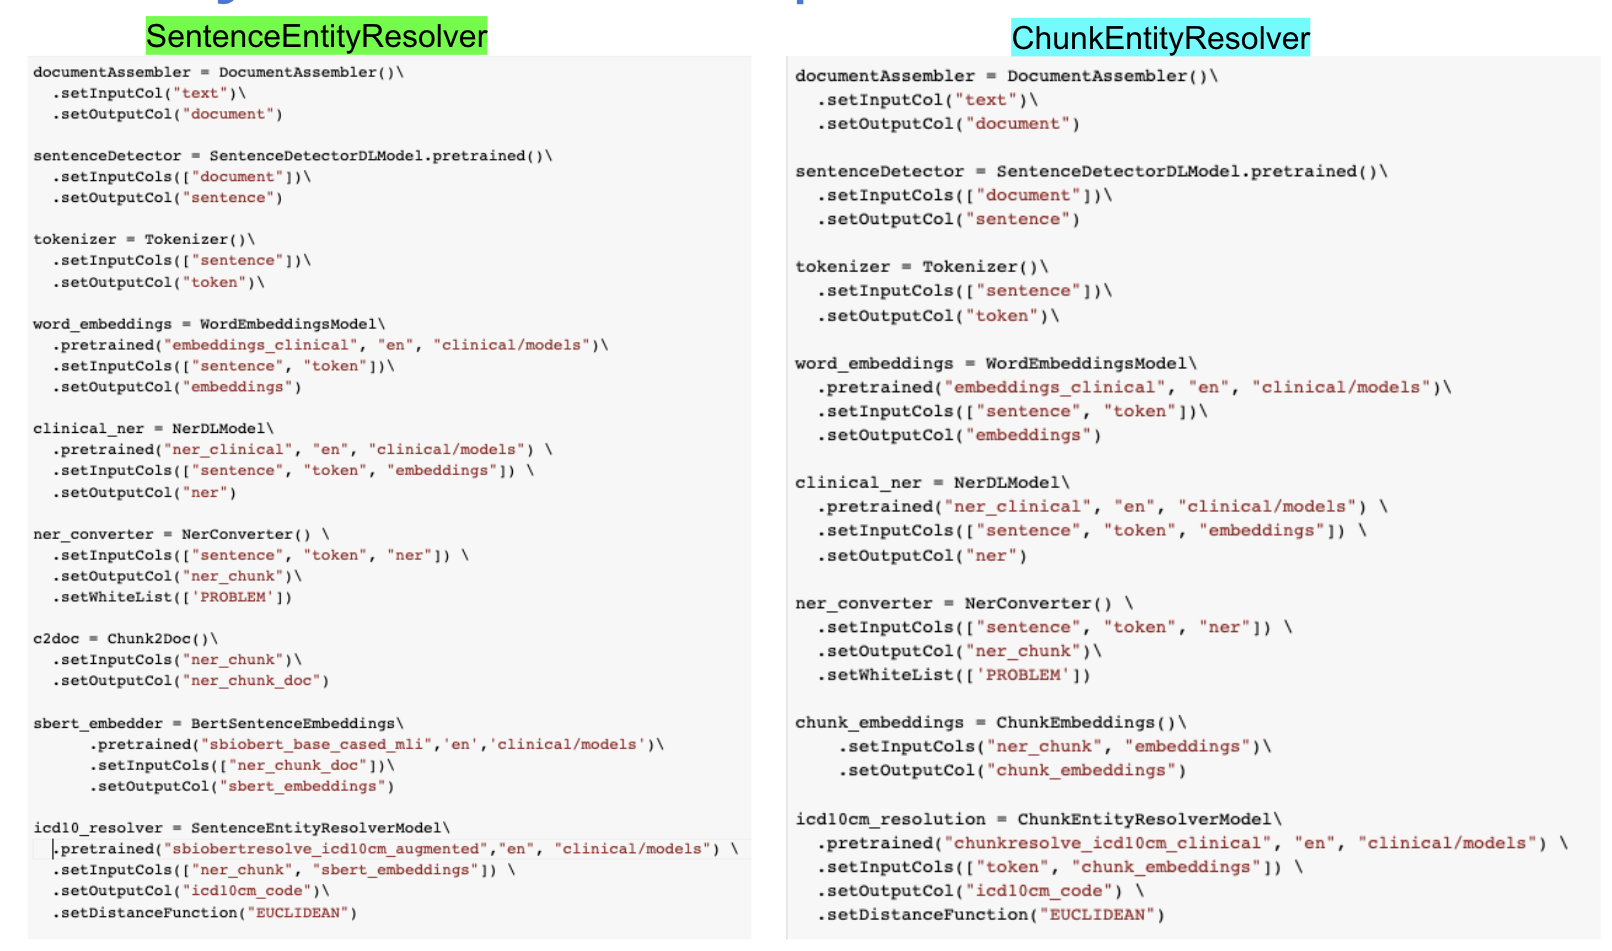

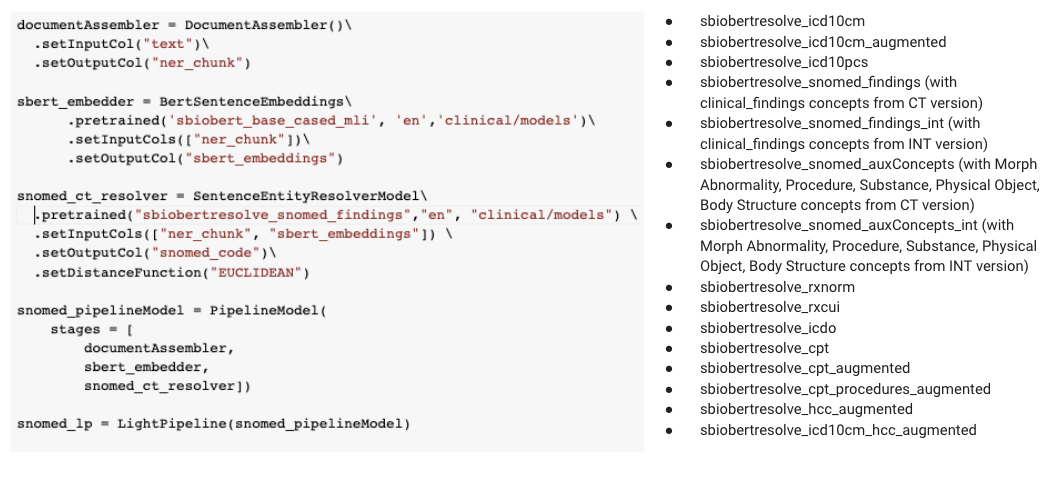

# Sentence Entity Resolver Models

**Writing a Generic Function For Getting the Codes**

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 0)


def get_codes (lp, text, vocab='icd10cm_code', hcc=False):
    
    full_light_result = lp.fullAnnotate(text)

    chunks = []
    codes = []
    begin = []
    end = []
    resolutions=[]
    all_distances =[]
    all_codes=[]
    all_cosines = []
    all_k_aux_labels=[]

    for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][vocab]):
            
        begin.append(chunk.begin)
        end.append(chunk.end)
        chunks.append(chunk.result)
        codes.append(code.result) 
        all_codes.append(code.metadata['all_k_results'].split(':::'))
        resolutions.append(code.metadata['all_k_resolutions'].split(':::'))
        all_distances.append(code.metadata['all_k_distances'].split(':::'))
        all_cosines.append(code.metadata['all_k_cosine_distances'].split(':::'))
        if hcc:
            try:
                all_k_aux_labels.append(code.metadata['all_k_aux_labels'].split(':::'))
            except:
                all_k_aux_labels.append([])
        else:
            all_k_aux_labels.append([])

    df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 'code':codes, 'all_codes':all_codes, 
                       'resolutions':resolutions, 'all_k_aux_labels':all_k_aux_labels,'all_distances':all_cosines})
    
    if hcc:

        df['billable'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[0] for i in x])
        df['hcc_status'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[1] for i in x])
        df['hcc_score'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[2] for i in x])

    df = df.drop(['all_k_aux_labels'], axis=1)
    
    return df



## Sentence Entity Resolver (RxNorm)

RxNorm is a second vocabulary for prescription drugs. RxNorm provides a set of codes for clinical drugs, which are the combination of active ingredients, dose form, and strength of a drug. For example, the RxNorm code for ciprofloxacin 500 mg 24-hour extended-release tablet (the generic name for Cipro XR 500 mg) is RX10359383, regardless of brand or packaging.

The goal of RxNorm is to allow computer systems to communicate drug-related information efficiently and unambiguously. Produced by the National Library of Medicine (NLM), RxNorm is available for distribution in both Metathesaurus Relation (MR) and Rich Release Format (RRF) tables. Currently there are no RxNorm names available for drugs with more than four active ingredients, those that are sold over the counter (OTC) or those that are international, due to the lack of appropriate information available about such drugs. 

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sbert_embeddings")
    
rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm","en", "clinical/models") \
      .setInputCols(["ner_chunk", "sbert_embeddings"]) \
      .setOutputCol("rxnorm_code")\
      .setDistanceFunction("EUCLIDEAN")

rxnorm_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp = LightPipeline(rxnorm_pipelineModel)


sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_rxnorm download started this may take some time.
Approximate size to download 802.6 MB
[OK!]


In [ ]:
text = 'metformin 100 mg'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 35.3 ms, sys: 13.2 ms, total: 48.6 ms
Wall time: 5.63 s


chunks  ...                                                                                                                                                                                             all_distances
0  metformin 100 mg  ...  [0.0235, 0.0376, 0.0505, 0.0658, 0.0670, 0.0684, 0.0697, 0.0770, 0.0765, 0.0775, 0.0804, 0.0818, 0.0807, 0.0811, 0.0812, 0.0811, 0.0828, 0.0844, 0.0846, 0.0840, 0.0844, 0.0850, 0.0851, 0.0851, 0.0876]

[1 rows x 7 columns]

In [ ]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 14.6 ms, sys: 1.27 ms, total: 15.8 ms
Wall time: 668 ms


chunks  ...                                                                                                                                                                                             all_distances
0  aspirin 10 meq/ 5 ml oral sol  ...  [0.0678, 0.0918, 0.0927, 0.0940, 0.0932, 0.0960, 0.0970, 0.0980, 0.1010, 0.0989, 0.1004, 0.1028, 0.1008, 0.0995, 0.1004, 0.1024, 0.1044, 0.1028, 0.1033, 0.1042, 0.1035, 0.1053, 0.1086, 0.1078, 0.1094]

[1 rows x 7 columns]

### RxNorm with DrugNormalizer

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk_v0")

drug_normalizer = DrugNormalizer() \
      .setInputCols("ner_chunk_v0") \
      .setOutputCol("ner_chunk") \
      .setPolicy('all')

rxnorm_pipelineModel2 = PipelineModel(
    stages = [
        documentAssembler,
        drug_normalizer,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp2 = LightPipeline(rxnorm_pipelineModel2)

In [ ]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp2, text, vocab='rxnorm_code')

CPU times: user 11.2 ms, sys: 4.91 ms, total: 16.1 ms
Wall time: 668 ms


chunks  ...                                                                                                                                                                                             all_distances
0  aspirin 2 meq/ml oral solution  ...  [0.0347, 0.0566, 0.0748, 0.0753, 0.0912, 0.0944, 0.0947, 0.1040, 0.1039, 0.1125, 0.1155, 0.1166, 0.1098, 0.1149, 0.1154, 0.1178, 0.1154, 0.1184, 0.1196, 0.1211, 0.1212, 0.1196, 0.1205, 0.1236, 0.1175]

[1 rows x 7 columns]

## Sentence Entity Resolver (ICD-10CM)

##  ICD10 background info

ICD-10-CM vs. ICD-10-PCS

With the transition to ICD-10, in the United States, ICD-9 codes are segmented into ICD-10-CM and ICD-10-PCS codes. **The "CM" in ICD-10-CM codes stands for clinical modification**; ICD-10-CM codes were developed by the Centers for Disease Control and Prevention in conjunction with the National Center for Health Statistics (NCHS), for outpatient medical coding and reporting in the United States, as published by the World Health Organization (WHO).

**The "PCS" in ICD-10-PCS codes stands for the procedural classification system**. ICD-10-PCS is a completely separate medical coding system from ICD-10-CM, containing an additional 87,000 codes for use ONLY in United States inpatient, hospital settings. The procedure classification system (ICD-10-PCS) was developed by the Centers for Medicare and Medicaid Services (CMS) in conjunction with 3M Health Information Management (HIM).

ICD-10-CM codes add increased specificity to their ICD-9 predecessors, growing to five times the number of codes as the present system; a total of 68,000 clinical modification diagnosis codes. ICD-10-CM codes provide the ability to track and reveal more information about the quality of healthcare, allowing healthcare providers to better understand medical complications, better design treatment and care, and better comprehend and determine the outcome of care.

ICD-10-PCS is used only for inpatient, hospital settings in the United States, and is meant to replace volume 3 of ICD-9 for facility reporting of inpatient procedures. Due to the rapid and constant state of flux in medical procedures and technology, ICD-10-PCS was developed to accommodate the changing landscape. Common procedures, lab tests, and educational sessions that are not unique to the inpatient, hospital setting have been omitted from ICD-10-PCS.

ICD-10 is confusing enough when you’re trying to digest the differences between ICD-9 and ICD-10, but there are also different types of ICD-10 codes that providers should be aware of.


**Primary difference between ICD-10-CM and ICD-10-PCS**

When most people talk about ICD-10, they are referring to ICD-10CM. This is the code set for diagnosis coding and is used for all healthcare settings in the United States. ICD-10PCS, on the other hand, is used in hospital inpatient settings for inpatient procedure coding.

ICD-10-CM breakdown

- Approximately 68,000 codes
- 3–7 alphanumeric characters
- Facilitates timely processing of claims


ICD-10-PCS breakdown

- Will replace ICD-9-CM for hospital inpatient use only. 
- ICD-10-PCS will not replace CPT codes used by physicians. According to HealthCare Information Management, Inc. (HCIM), “Its only intention is to identify inpatient facility services in a way not directly related to physician work, but directed towards allocation of hospital services.”

- 7 alphanumeric characters

ICD-10-PCS is very different from ICD-9-CM procedure coding due to its ability to be more specific and accurate. “This becomes increasingly important when assessing and tracking the quality of medical processes and outcomes, and compiling statistics that are valuable tools for research,” according to HCIM.

**Hierarchical Condition Category (HCC)**

Hierarchical condition category (HCC) coding is a risk-adjustment model originally designed to estimate future health care costs for patients. The Centers for Medicare & Medicaid Services (CMS) HCC model was initiated in 2004 but is becoming increasingly prevalent as the environment shifts to value-based payment models.

Hierarchical condition category relies on ICD-10 coding to assign risk scores to patients. Each HCC is mapped to an ICD-10 code. Along with demographic factors (such as age and gender), insurance companies use HCC coding to assign patients a risk adjustment factor (RAF) score. Using algorithms, insurances can use a patient’s RAF score to predict costs. For example, a patient with few serious health conditions could be expected to have average medical costs for a given time. However, a patient with multiple chronic conditions would be expected to have higher health care utilization and costs.

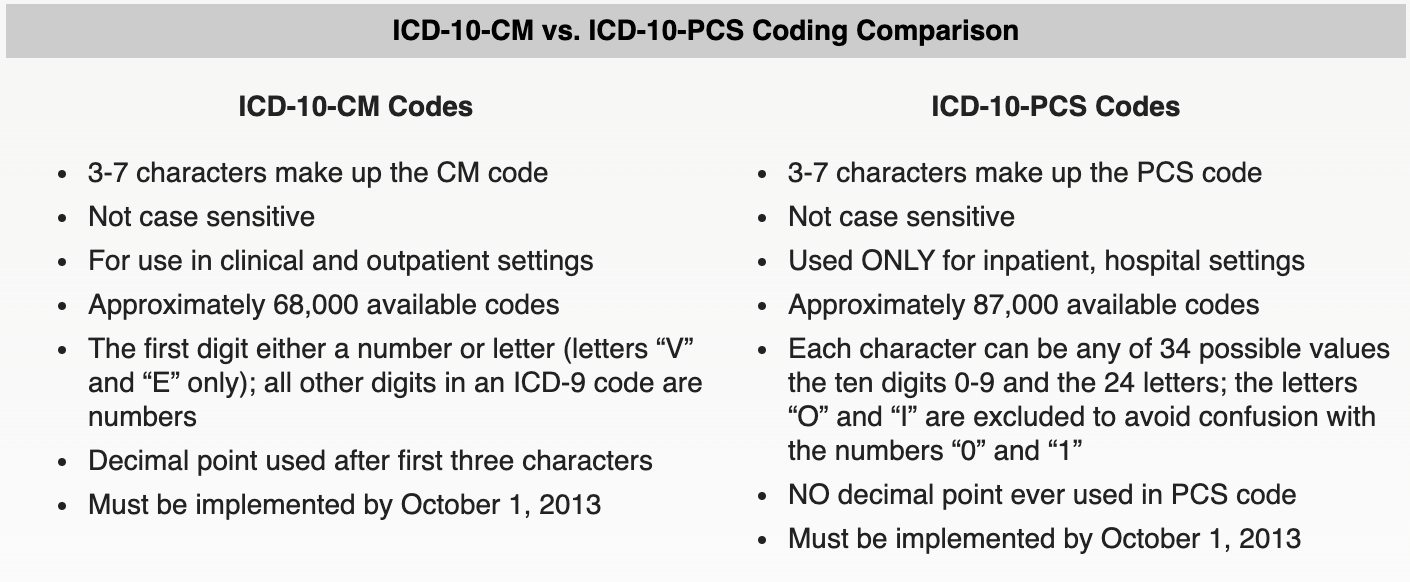

## ICD10 coding Pipeline creation.

A common NLP problem in biomedical aplications is to identify the presence of clinical entities in a given text. This clinical entities could be diseases, symptoms, drugs, results of clinical investigations or others.

To convert a sentence or document into a vector for semantic search or to build a recommendation system, one of the most popularly advised approaches is to pass the text through a transformer model like BERT, etc, and collect the embedding vector of CLS token or average out the embeddings of the tokens from the last layer to get a single vector.

Truth be told, this approach of finding similar documents through embedding the CLS token or average embedding of the last layer performs much worse than averaging of word2vec/Glove embedding to form a sentence/document vector.
On top of that, word2vec/Glove averaging is very fast to run when compared to extracting a vector through the transformer model.

A better approach for transformer-based embedding is to use fine-tuned Siamese network variants (SBERT etc) that are trained to embed similar sentences/ documents to a closer embedding space and separate the non-similar ones. That’s what we are doing here at Sentence Resolvers and it is why we outperform Chunk Resolvers.

Otherwise, the raw embedding vectors (CLS, etc) from the last layers of these transformer models don't yield any superior results for similarity search when compared to avg word2vec/Glove embeddings.

Here is a list of some of the sentence entity resolver models;

- sbiobertresolve_icd10cm 
- sbiobertresolve_icd10cm_augmented
- sbiobertresolve_hcc_augmented
- sbiobertresolve_icd10cm_augmented_billable_hcc
- sbertresolve_icd10cm_slim_billable_hcc_med
- sbiobertresolve_icd10cm_slim_billable_hcc
- sbiobertresolve_icd10pcs
- sbiobertresolve_snomed_findings (with clinical_findings concepts from CT version)
- sbiobertresolve_snomed_findings_int  (with clinical_findings concepts from INT version)
- sbiobertresolve_snomed_auxConcepts (with Morph Abnormality, Procedure, Substance, Physical Object, Body Structure concepts from CT version)
- sbiobertresolve_snomed_auxConcepts_int  (with Morph Abnormality, Procedure, Substance, Physical Object, Body Structure concepts from INT version)
- sbertresolve_snomed_bodyStructure_med
- sbiobertresolve_rxnorm
- sbiobertresolve_rxcui
- sbiobertresolve_icdo
- sbiobertresolve_icdo_augmented
- sbiobertresolve_cpt
- sbiobertresolve_cpt_procedures_augmented
- sbiobertresolve_loinc
- sbiobertresolve_HPO
- sbiobertresolve_umls_major_concepts
- sbiobertresolve_umls_findings

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- all_k_resolutions -> All codes descriptions
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId

We will now create a new pipeline that from each of these problems will try to assign an ICD10 base on the content, the sentence embeddings and some pretrained models for ICD10 annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- MedicalNerModel ([sentence, token, embeddings] -> ner)

- NerConverter (["sentence, token, ner] -> ner_chunk

- Chunk2Doc (ner_chunk) -> ner_chunk_doc

- BertSentenceEmbeddings (ner_chunk_doc) -> sbert_embeddings

- SentenceEntityResolverModel ([ner_chunk, sbert_embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their ICD10 codes (resolution)

Most of the annotators in this pipeline have been already created for the previous pipeline, but we need to create four additional annotators: NerConverter, Chunk2Doc, BertSentenceEmbeddings,  SentenceEntityResolverModel for ICD10CM.

`setPreservePosition(True)` takes exactly the original indices (under some tokenization conditions it might include some undesires chars like `")","]"...)`

`setPreservePosition(False)` takes adjusted indices based on substring indexingOf the first (for begin) and last (for end) tokens

also with internal we can use the `greedyMode` which will marge consecutive entities of same type regardless of b-boundaries


<h1>!!! Warning !!!</h1> 

**If you get an error related to Java port not found 55, it is probably because that the Colab memory cannot handle the model and the Spark session died. In that case, try on a larger machine or restart the kernel at the top and then come back here and rerun.**

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

# Sentence Detector DL annotator, processes various sentences per line
sentenceDetectorDL = SentenceDetectorDLModel\
      .pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
      .setInputCols(["document"]) \
      .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")
  

# Named Entity Recognition for clinical concepts.
clinical_ner = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")

ner_converter_icd = NerConverterInternal() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")\
      .setWhiteList(['problem'])\
      .setPreservePosition(False)

c2doc = Chunk2Doc()\
      .setInputCols("ner_chunk")\
      .setOutputCol("ner_chunk_doc") 

sbert_embedder = BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk_doc"])\
      .setOutputCol("sbert_embeddings")
    
icd_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
     .setInputCols(["ner_chunk", "sbert_embeddings"]) \
     .setOutputCol("icd10cm_code")\
     .setDistanceFunction("EUCLIDEAN")
    

# Build up the pipeline
resolver_pipeline = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        c2doc,
        sbert_embedder,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")

model = resolver_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
Approximate size to download 865 MB
[OK!]


In [ ]:
model.stages

[DocumentAssembler_3e8ce057ff8c,
 SentenceDetectorDLModel_d2546f0acfe2,
 REGEX_TOKENIZER_c554408bec04,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 NerConverterInternal_a2f5154c18ea,
 Chunk2Doc_ba80c119457d,
 BERT_SENTENCE_EMBEDDINGS_0bee53f1b2cc,
 ENTITY_b3096b853e8d]

### Create a SparkDataFrame with the content

Now we will create a sample Spark dataframe with our clinical note example.

In this example we are working over a unique clinical note. In production environments a table with several of those clinical notes could be distributed in a cluster and be run in large scale systems.

In [ ]:
clinical_note = (
    'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years '
    'prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior '
    'episode of HTG-induced pancreatitis three years prior to presentation, associated '
    'with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, '
    'presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. '
    'Two weeks prior to presentation, she was treated with a five-day course of amoxicillin '
    'for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin '
    'for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months '
    'at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; '
    'significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent '
    'laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, '
    'creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) '
    '10%, and venous pH 7.27. Serum lipase was normal at 43 U/L. Serum acetone levels could not be assessed '
    'as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for '
    'starvation ketosis, as she reported poor oral intake for three days prior to admission. However, '
    'serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL, the anion gap '
    'was still elevated at 21, serum bicarbonate was 16 mmol/L, triglyceride level peaked at 2050 mg/dL, and '
    'lipase was 52 U/L. The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - '
    'the original sample was centrifuged and the chylomicron layer removed prior to analysis due to '
    'interference from turbidity caused by lipemia again. The patient was treated with an insulin drip '
    'for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL, within '
    '24 hours. Her euDKA was thought to be precipitated by her respiratory tract infection in the setting '
    'of SGLT2 inhibitor use. The patient was seen by the endocrinology service and she was discharged on '
    '40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg '
    'two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely. She '
    'had close follow-up with endocrinology post discharge.'
)

data_ner = spark.createDataFrame([[clinical_note]]).toDF("text")

In [ ]:
data_ner.show(truncate = 100)


+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+



Lets apply some HTML formating to see the results of the pipeline in a nicer layout:



In [ ]:
icd10_lp = LightPipeline(model)

light_result = icd10_lp.fullAnnotate(clinical_note)

from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

#visualiser.display(light_result[0], label_col='entities', document_col='document')

# Change color of an entity label

visualiser.set_label_colors({'PROBLEM':'#008080'})
visualiser.display(light_result[0], label_col='ner_chunk')

# Set label filter
# visualiser.display(light_result, label_col='ner_chunk', document_col='document',
                   #labels=['PROBLEM','TEST'])

In [ ]:
icd10_res = model.transform(data_ner)

In [ ]:
%time icd10_res.select("icd10cm_code.metadata").show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                            metadata|
+----------------------------------------------------------------------------------------------------+
|[{all_k_results -> O24919:::E119:::O2441:::O24419:::O2443:::O24439:::Z8632:::O24319:::O2431:::O24...|
+----------------------------------------------------------------------------------------------------+

CPU times: user 98.4 ms, sys: 10.1 ms, total: 109 ms
Wall time: 22 s


In [ ]:
%%time

import pandas as pd

pd.set_option('display.max_colwidth', 0)

icd10_df = icd10_res.select(F.explode(F.arrays_zip('ner_chunk.result', 
                                                   'ner_chunk.metadata', 
                                                   'icd10cm_code.result', 
                                                   'icd10cm_code.metadata')).alias("cols")) \
                            .select(F.expr("cols['0']").alias("ner_chunk"),
                                     F.expr("cols['1']['entity']").alias("entity"), 
                                     F.expr("cols['2']").alias("icd10_code"),
                                     F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                     F.expr("cols['3']['all_k_resolutions']").alias("resolutions"),
                                     F.expr("cols['3']['all_k_aux_labels']").alias("hcc_list")).toPandas()
 
 
codes = []
resolutions = []
hcc_all = []

for code, resolution, hcc in zip(icd10_df['all_codes'], icd10_df['resolutions'], icd10_df['hcc_list']):
    
    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    hcc_all.append(hcc.split(":::"))

icd10_df['all_codes'] = codes  
icd10_df['resolutions'] = resolutions
icd10_df['hcc_list'] = hcc_all

CPU times: user 331 ms, sys: 44.8 ms, total: 376 ms
Wall time: 1min 20s


In [ ]:
icd10_df.head(15)

ner_chunk  ...                                                                                                                                                                                    hcc_list
0   gestational diabetes mellitus          ...  [1||0||0, 1||1||19, 0||0||0, 1||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0, 0||0||0, 0||0||0, 1||0||0, 0||0||0]                                                                    
1   subsequent type two diabetes mellitus  ...  [0||0||0, 1||1||18, 1||1||19, 0||0||0, 1||1||19, 0||0||0, 1||1||75/18, 1||1||75/18, 1||1||108/18, 1||0||0, 0||0||0]                                                                       
2   T2DM                                   ...  [0||0||0, 1||1||19, 1||1||18, 0||0||0, 1||1||19, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||1||18, 1||0||0, 0||0||0, 1||1||19, 1||1||18]                                                      
3   HTG-induced pancreatitis               ...  [0||0||0, 1||0||0, 0||0||0, 0||0||0, 1||0||0, 0||0||0, 0||0||0, 0||0||0, 0||0||0]                                                                                                         
4   an acute hepatitis                     ...  [1||0||0, 0||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0, 1||0||0, 0||0||0, 1||0||0, 1||0||0]                                                                              
5   obesity                                ...  [1||0||0, 0||0||0, 1||1||22, 1||0||0, 1||0||0, 1||0||0, 0||0||0, 1||0||0]                                                                                                                 
6   a body mass index                      ...  [1||0||0, 1||0||0, 1||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0]                                                   
7   polyuria                               ...  [1||0||0, 0||0||0, 0||0||0, 1||0||0, 1||1||23, 1||0||0, 0||0||0, 1||0||0, 1||1||141, 1||0||0, 1||0||0, 1||1||141]                                                                         
8   polydipsia                             ...  [1||0||0, 1||1||nan, 0||0||0, 1||0||0, 1||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||1||40, 1||0||0]                                       
9   poor appetite                          ...  [1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||1||21, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0]                                
10  vomiting                               ...  [1||0||0, 0||0||0, 0||0||0, 1||0||0, 1||1||nan, 0||0||0, 1||0||0, 1||0||0, 1||0||0]                                                                                                       
11  a respiratory tract infection          ...  [1||0||0, 0||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0, 0||0||0, 0||0||0]                                                            
12  T2DM                                   ...  [0||0||0, 1||1||19, 1||1||18, 0||0||0, 1||1||19, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||1||18, 1||0||0, 0||0||0, 1||1||19, 1||1||18]                                                      
13  HTG                                    ...  [1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||1||nan, 1||0||0, 1||0||0, 1||0||0, 1||1||19, 1||1||nan, 1||1||23, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0]
14  dry oral mucosa                        ...  [1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0]                                                            

[15 rows x 6 columns]

**The values in `billable`, `hcc_score` and `hcc_status` columns are seperated by || and we will change them to a list.**

In [ ]:
def extract_billable(bil):
  
    billable = []
    status = []
    score = []
 
    for b in bil:
        billable.append(b.split("||")[0])
        status.append(b.split("||")[1])
        score.append(b.split("||")[2])

    return (billable, status, score)
 
    
icd10_df["billable"] = icd10_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]    
icd10_df["hcc_status"] = icd10_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
icd10_df["hcc_score"] = icd10_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

icd10_df.drop("hcc_list", axis=1, inplace= True)

In [ ]:
icd10_df.head(15)

ner_chunk  ...                                                           hcc_score
0   gestational diabetes mellitus          ...  [0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                          
1   subsequent type two diabetes mellitus  ...  [0, 18, 19, 0, 19, 0, 75/18, 75/18, 108/18, 0, 0]                 
2   T2DM                                   ...  [0, 19, 18, 0, 19, 0, 0, 0, 0, 18, 0, 0, 19, 18]                  
3   HTG-induced pancreatitis               ...  [0, 0, 0, 0, 0, 0, 0, 0, 0]                                       
4   an acute hepatitis                     ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                              
5   obesity                                ...  [0, 0, 22, 0, 0, 0, 0, 0]                                         
6   a body mass index                      ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                     
7   polyuria                               ...  [0, 0, 0, 0, 23, 0, 0, 0, 141, 0, 0, 141]                         
8   polydipsia                             ...  [0, nan, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0]               
9   poor appetite                          ...  [0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0]              
10  vomiting                               ...  [0, 0, 0, 0, nan, 0, 0, 0, 0]                                     
11  a respiratory tract infection          ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                        
12  T2DM                                   ...  [0, 19, 18, 0, 19, 0, 0, 0, 0, 18, 0, 0, 19, 18]                  
13  HTG                                    ...  [0, 0, 0, 0, 0, 0, nan, 0, 0, 0, 19, nan, 23, 0, 0, 0, 0, 0, 0, 0]
14  dry oral mucosa                        ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                        

[15 rows x 8 columns]

**Lets try `sbertresolve_icd10cm_slim_billable_hcc_med` model was trained with `sbert_jsl_medium_uncased` embeddings.**

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

jsl_sbert_embedder = BertSentenceEmbeddings.pretrained('sbert_jsl_medium_uncased','en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sbert_embeddings")
    
icd_resolver_med = SentenceEntityResolverModel.pretrained("sbertresolve_icd10cm_slim_billable_hcc_med","en", "clinical/models") \
     .setInputCols(["ner_chunk", "sbert_embeddings"]) \
     .setOutputCol("icd10cm_code")\
     .setDistanceFunction("EUCLIDEAN")

icd_medPipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        jsl_sbert_embedder,
        icd_resolver_med])

icd_med_lp = LightPipeline(icd_medPipelineModel)

sbert_jsl_medium_uncased download started this may take some time.
Approximate size to download 146.8 MB
[OK!]
sbertresolve_icd10cm_slim_billable_hcc_med download started this may take some time.
Approximate size to download 580.3 MB
[OK!]


In [ ]:
text = 'gestational diabetes mellitus'

%time get_codes (icd_med_lp, text, vocab='icd10cm_code')

CPU times: user 20.9 ms, sys: 3.18 ms, total: 24.1 ms
Wall time: 1.29 s


chunks  ...                                                             all_distances
0  gestational diabetes mellitus  ...  [0.0000, 0.0000, 0.0000, 0.0330, 0.0429, 0.0596, 0.0618, 0.0719, 0.0873]

[1 rows x 7 columns]

In [ ]:
text = 'T2DM'

%time get_codes (icd_med_lp, text, vocab='icd10cm_code')

CPU times: user 15.1 ms, sys: 1.32 ms, total: 16.4 ms
Wall time: 555 ms


chunks  ...                                                                                                                                                                                             all_distances
0  T2DM   ...  [0.0000, 0.3226, 0.3402, 0.3381, 0.3536, 0.3454, 0.3351, 0.3510, 0.3351, 0.3455, 0.3474, 0.3552, 0.3547, 0.3641, 0.3590, 0.3569, 0.3612, 0.3512, 0.3510, 0.3704, 0.3623, 0.3607, 0.3713, 0.3597, 0.3610]

[1 rows x 7 columns]

In [ ]:
text = 'dry oral mucosa'

%time get_codes (icd_med_lp, text, vocab='icd10cm_code')

CPU times: user 12.6 ms, sys: 1.43 ms, total: 14 ms
Wall time: 477 ms


chunks  ...                                                                                                                     all_distances
0  dry oral mucosa  ...  [0.1347, 0.2658, 0.2684, 0.2762, 0.2780, 0.2780, 0.3073, 0.3079, 0.3081, 0.3002, 0.3079, 0.3244, 0.3238, 0.3357, 0.3237, 0.3480]

[1 rows x 7 columns]

## Sentence Entity Resolver (CPT)

The Current Procedural Terminology (CPT) code set is a medical code set maintained by the American Medical Association. The CPT code set describes medical, surgical, and diagnostic services and is designed to communicate uniform information about medical services and procedures among physicians, coders, patients, accreditation organizations, and payers for administrative, financial, and analytical purposes.

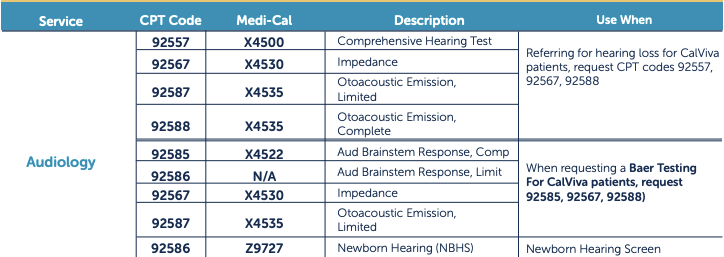

**We will create a pipeline to detect bodyparts and imaging tests entities and their relations. Then we will use these related chunks in CPT resolver model to get their CPT code.**

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

# Sentence Detector DL annotator, processes various sentences per line
sentenceDetectorDL = SentenceDetectorDLModel\
      .pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
      .setInputCols(["document"]) \
      .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")
    
dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

# Named Entity Recognition for radiology reports.
clinical_ner = MedicalNerModel.pretrained("jsl_rd_ner_wip_greedy_clinical", "en", "clinical/models") \
   .setInputCols(["sentence", "token", "embeddings"]) \
   .setOutputCol("ner")

ner_chunker = NerConverter()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

re_model = RelationExtractionModel()\
    .pretrained("re_bodypart_directions", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["imagingtest-bodypart", "bodypart-imagingtest"])\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.5)
      

# Build up the pipeline
relation_pipeline = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        pos_tagger,
        dependency_parser,
        clinical_ner,
        ner_chunker,
        re_model
        ])


empty_data = spark.createDataFrame([['']]).toDF("text")

rel_model = relation_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
jsl_rd_ner_wip_greedy_clinical download started this may take some time.
Approximate size to download 14.6 MB
[OK!]
re_bodypart_directions download started this may take some time.
Approximate size to download 9.2 MB
[OK!]


In [ ]:
light_rel_model = LightPipeline(rel_model)

In [ ]:
def get_relations_df (results, col='relations'):
    rel_pairs=[]
    for rel in results[0][col]:
        rel_pairs.append(( 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
        ))

    rel_df = pd.DataFrame(rel_pairs, columns=['entity1','entity1_begin','entity1_end','chunk1',
                                              'entity2','entity2_end','entity2_end','chunk2', 
                                              'confidence'])
    
    # limit df columns to get entity and chunks with results only
    rel_df = rel_df.iloc[:,[0,3,4,7,8]]
    
    return rel_df

In [ ]:
text="Left shin pain. I have ordered x-ray of the left fibula and knee today. The patient will return to the clinic in 3 weeks. He is to call me in the interim for any problems."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

entity1 chunk1   entity2  chunk2 confidence
0  ImagingTest  x-ray  BodyPart  fibula  1.0      
1  ImagingTest  x-ray  BodyPart  knee    0.9458425

**Now we can use get CPT codes of these related chunks.**

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sbert_embeddings")
    
cpt_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_cpt_augmented","en", "clinical/models") \
      .setInputCols(["ner_chunk", "sbert_embeddings"]) \
      .setOutputCol("cpt_code")\
      .setDistanceFunction("EUCLIDEAN")


cpt_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        cpt_resolver])


cpt_lp = LightPipeline(cpt_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_cpt_augmented download started this may take some time.
Approximate size to download 137.6 MB
[OK!]


In [ ]:
text = 'fibula x-ray'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 150 ms, sys: 14.5 ms, total: 164 ms
Wall time: 29.2 s


chunks  ...                                                             all_distances
0  fibula x-ray  ...  [0.0895, 0.0970, 0.0970, 0.0970, 0.0970, 0.0970, 0.1360, 0.1364, 0.1474]

[1 rows x 7 columns]

In [ ]:
text = 'knee x-ray'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 14.9 ms, sys: 906 µs, total: 15.8 ms
Wall time: 565 ms


chunks  ...                                                                                                                     all_distances
0  knee x-ray  ...  [0.0000, 0.0000, 0.0907, 0.1096, 0.1171, 0.1309, 0.1472, 0.1472, 0.1472, 0.1472, 0.1472, 0.1483, 0.1483, 0.1538, 0.1527, 0.1527]

[1 rows x 7 columns]

In [ ]:
text="TECHNIQUE IN DETAIL: After informed consent was obtained from the patient and his mother, the chest was scanned with portable ultrasound."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

entity1 chunk1      entity2               chunk2 confidence
0  BodyPart  chest  ImagingTest  portable ultrasound  0.9999802

In [ ]:
text = 'chest portable ultrasound'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 12.7 ms, sys: 2.69 ms, total: 15.4 ms
Wall time: 583 ms


chunks  ...                                                                                     all_distances
0  chest portable ultrasound  ...  [0.1269, 0.1563, 0.1563, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582]

[1 rows x 7 columns]

In [ ]:
text="This 73 y/o patient had Brain CT on 1/12/95, with progressive memory and cognitive decline since 8/11/94."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

entity1 chunk1      entity2 chunk2 confidence
0  BodyPart  Brain  ImagingTest  CT     0.9999999

In [ ]:
text = 'brain CT'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 9.1 ms, sys: 2.22 ms, total: 11.3 ms
Wall time: 520 ms


chunks  ...                                             all_distances
0  brain CT  ...  [0.1265, 0.1371, 0.1414, 0.1414, 0.1414, 0.1470, 0.1599]

[1 rows x 7 columns]

## Sentence Entity Resolver (SNOMED)

SNOMED CT is one of a suite of designated standards for use in U.S. Federal Government systems for the electronic exchange of clinical health information and is also a required standard in interoperability specifications of the U.S. Healthcare Information Technology Standards Panel. The clinical terminology is owned and maintained by SNOMED International, a not-for-profit association. 

SNOMED CT:

- Is the most comprehensive and precise, multilingual health terminology in the world.
- Has been, and continues to be, developed collaboratively to ensure it meets the diverse needs and expectations of the worldwide medical profession.
- Assists with the electronic exchange of clinical health information.
- Can be mapped to other coding systems, such as ICD-9 and ICD-10, which helps facilitate semantic interoperability.
- Is accepted as a common global language for health terms in over 50 countries.
- Is a resource with extensive, scientifically validated clinical content

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sbert_embeddings")
    
snomed_ct_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_snomed_findings","en", "clinical/models") \
      .setInputCols(["ner_chunk", "sbert_embeddings"]) \
      .setOutputCol("snomed_code")\
      .setDistanceFunction("EUCLIDEAN")

snomed_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        snomed_ct_resolver])

snomed_lp = LightPipeline(snomed_pipelineModel)


sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_snomed_findings download started this may take some time.
Approximate size to download 1.3 GB
[OK!]


In [ ]:
text = 'bladder cancer'

%time get_codes (snomed_lp, text, vocab='snomed_code')

CPU times: user 27.1 ms, sys: 9.4 ms, total: 36.5 ms
Wall time: 1.77 s


chunks  ...                                                                                             all_distances
0  bladder cancer  ...  [0.0000, 0.0000, 0.0539, 0.0666, 0.0666, 0.0666, 0.0809, 0.0881, 0.0880, 0.0880, 0.0913, 0.0978, 0.1080]

[1 rows x 7 columns]

In [ ]:
text = 'atrial fibrillation'

%time get_codes (snomed_lp, text, vocab='snomed_code')

CPU times: user 15.2 ms, sys: 1.9 ms, total: 17.1 ms
Wall time: 1.02 s


chunks  ...                                                                                                     all_distances
0  atrial fibrillation  ...  [0.0000, 0.0000, 0.0000, 0.0185, 0.0220, 0.0265, 0.0273, 0.0356, 0.0395, 0.0479, 0.0498, 0.0533, 0.0532, 0.0532]

[1 rows x 7 columns]

## Sentence Entity Resolver (LOINC)

Logical Observation Identifiers Names and Codes (LOINC) is a database and universal standard for identifying medical laboratory observations. First developed in 1994, it was created and is maintained by the Regenstrief Institute, a US nonprofit medical research organization. LOINC was created in response to the demand for an electronic database for clinical care and management and is publicly available at no cost.

It is endorsed by the American Clinical Laboratory Association. Since its inception, the database has expanded to include not just medical laboratory code names but also nursing diagnosis, nursing interventions, outcomes classification, and patient care data sets.

LOINC applies universal code names and identifiers to medical terminology related to electronic health records. The purpose is to assist in the electronic exchange and gathering of clinical results (such as laboratory tests, clinical observations, outcomes management and research). LOINC has two main parts: laboratory LOINC and clinical LOINC.

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sbert_embeddings")
    
loinc_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_loinc", "en", "clinical/models") \
      .setInputCols(["ner_chunk", "sbert_embeddings"]) \
      .setOutputCol("loinc_code")\
      .setDistanceFunction("EUCLIDEAN")

loinc_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        loinc_resolver])

loinc_lp = LightPipeline(loinc_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_loinc download started this may take some time.
Approximate size to download 212.6 MB
[OK!]


In [ ]:
text = 'FLT3 gene mutation analysis'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 47.3 ms, sys: 10.2 ms, total: 57.5 ms
Wall time: 6.77 s


chunks  ...                                                                                                                                                                                             all_distances
0  FLT3 gene mutation analysis  ...  [0.1369, 0.1369, 0.1516, 0.1571, 0.1571, 0.1571, 0.1594, 0.1641, 0.1635, 0.1635, 0.1692, 0.1651, 0.1701, 0.1701, 0.1716, 0.1739, 0.1719, 0.1797, 0.1797, 0.1771, 0.1810, 0.1744, 0.1803, 0.1845, 0.1804]

[1 rows x 7 columns]

In [ ]:
text = 'Hematocrit'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 9.27 ms, sys: 4.22 ms, total: 13.5 ms
Wall time: 394 ms


chunks  ...                                                                                                                                                                                             all_distances
0  Hematocrit  ...  [0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732]

[1 rows x 7 columns]

## Sentence Entity Resolver (UMLS)

Unified Medical Language System (UMLS) integrates and distributes key terminology, classification and coding standards, and associated resources to promote creation of more effective and interoperable biomedical information systems and services, including electronic health records.

The UMLS, or Unified Medical Language System, is a set of files and software that brings together many health and biomedical vocabularies and standards to enable interoperability between computer systems.

The Metathesaurus forms the base of the UMLS and comprises over 1 million biomedical concepts and 5 million concept names, all of which stem from the over 100 incorporated controlled vocabularies and classification systems. Some examples of the incorporated controlled vocabularies are CPT, ICD-10, MeSH, SNOMED CT, DSM-IV, LOINC, WHO Adverse Drug Reaction Terminology, UK Clinical Terms, RxNorm, Gene Ontology, and OMIM

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sbert_embeddings")
    
umls_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_umls_major_concepts", "en", "clinical/models") \
      .setInputCols(["ner_chunk", "sbert_embeddings"]) \
      .setOutputCol("umls_code")\
      .setDistanceFunction("EUCLIDEAN")

umls_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        umls_resolver])

umls_lp = LightPipeline(umls_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_umls_major_concepts download started this may take some time.
Approximate size to download 817.3 MB
[OK!]


In [ ]:
# Injuries & poisoning
text = 'food poisoning'

%time get_codes (umls_lp, text, vocab='umls_code')

CPU times: user 14.3 ms, sys: 75 µs, total: 14.4 ms
Wall time: 672 ms


chunks  ...                                                                                             all_distances
0  food poisoning  ...  [0.0000, 0.0507, 0.0660, 0.0668, 0.0871, 0.0876, 0.0913, 0.0981, 0.0989, 0.1006, 0.1033, 0.1042, 0.1041]

[1 rows x 7 columns]

In [ ]:
# clinical findings
text = 'type two diabetes mellitus'

%time get_codes (umls_lp, text, vocab='umls_code')

CPU times: user 18.4 ms, sys: 1.64 ms, total: 20.1 ms
Wall time: 680 ms


chunks  ...                                                                                                                                             all_distances
0  type two diabetes mellitus  ...  [0.0438, 0.0568, 0.0618, 0.0697, 0.0780, 0.0891, 0.0910, 0.0883, 0.0937, 0.0940, 0.0939, 0.0971, 0.1031, 0.1062, 0.1087, 0.1104, 0.1116, 0.1201, 0.1147]

[1 rows x 7 columns]

## Sentence Entity Resolver (HPO)

The Human Phenotype Ontology (HPO) is a formal ontology of human phenotypes. Developed in collaboration with members of the Open Biomedical Ontologies Foundry, HPO currently contains over 13,000 terms and over 156,000 annotations to hereditary diseases. Data from Online Mendelian Inheritance in Man and medical literature were used to generate the terms currently in the HPO. The ontology contains over 50,000 annotations between phenotypes and hereditary disease.

Each term in the HPO describes a clinical abnormality. These may be general terms, such as Abnormal ear morphology or very specific ones such as Chorioretinal atrophy. Each term is also assigned to one of the five subontologies. The terms have a unique ID such as HP:0001140 and a label such as *Epibulbar dermoid*.

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sbert_embeddings")
    
hpo_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_HPO", "en", "clinical/models") \
      .setInputCols(["ner_chunk", "sbert_embeddings"]) \
      .setOutputCol("umls_code")\
      .setDistanceFunction("EUCLIDEAN")

hpo_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        hpo_resolver])

hpo_lp = LightPipeline(hpo_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_HPO download started this may take some time.
Approximate size to download 97.9 MB
[OK!]


In [ ]:
text = 'schizophrenia '

%time get_codes (hpo_lp, text, vocab='umls_code')

CPU times: user 10.6 ms, sys: 2.66 ms, total: 13.3 ms
Wall time: 218 ms


chunks  ...                                                                                                                                                                     all_distances
0  schizophrenia   ...  [0.0000, 0.1172, 0.1488, 0.1599, 0.1877, 0.1898, 0.1923, 0.2033, 0.2163, 0.2113, 0.2166, 0.2257, 0.2202, 0.2345, 0.2431, 0.2389, 0.2497, 0.2438, 0.2578, 0.2483, 0.2604, 0.2455]

[1 rows x 7 columns]

In [ ]:
text = 'Abnormality of the upper limb'

%time get_codes (hpo_lp, text, vocab='umls_code')

CPU times: user 12.4 ms, sys: 6.16 ms, total: 18.6 ms
Wall time: 234 ms


chunks  ...                                                                                                                                             all_distances
0  Abnormality of the upper limb  ...  [0.0203, 0.0353, 0.0353, 0.0541, 0.0645, 0.0644, 0.0719, 0.0756, 0.0789, 0.0830, 0.0829, 0.0827, 0.0860, 0.0881, 0.0889, 0.0899, 0.0901, 0.0900, 0.0911]

[1 rows x 7 columns]

In [ ]:
text = 'Muscle haemorrhage'

%time get_codes (hpo_lp, text, vocab='umls_code')

CPU times: user 10.6 ms, sys: 4.25 ms, total: 14.8 ms
Wall time: 623 ms


chunks  ...                                                                                                                     all_distances
0  Muscle haemorrhage  ...  [0.0516, 0.0939, 0.1355, 0.1515, 0.1608, 0.1641, 0.1653, 0.1648, 0.1670, 0.1696, 0.1671, 0.1755, 0.1691, 0.1726, 0.1712, 0.1775]

[1 rows x 7 columns]

# Healthcare Codes Mapping by Using Pretrained Pipelines

In Spark NLP, there are pretrained pipelines that can map these healthcare codes each other. Here is a list of these pipelines:

- `icd10cm_snomed_mapping` : ICD10 Codes to Snomed Codes
- `snomed_icd10cm_mapping` : Snomed Codes to ICD Codes
- `icd10cm_umls_mapping`   : ICD Codes to UMLS Codes
- `snomed_umls_mapping`    : Snomed Codes to UMLS Codes
- `rxnorm_umls_mapping`    : RxNorm Codes to UMLS Codes
- `mesh_umls_mapping`      : MeSH Codes to UMLS Codes
- `rxnorm_mesh_mapping`    : RxNorm Codes to MeSH Codes

Lets show an example of ICD codes mapping to Snomed Codes to show how these pipelines work. 

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

In [ ]:
icd10_snomed_pipeline = PretrainedPipeline("icd10cm_snomed_mapping", "en", "clinical/models")

icd10cm_snomed_mapping download started this may take some time.
Approx size to download 514.5 KB
[OK!]


In [ ]:
icd10_snomed_pipeline.annotate('M89.50 I288 H16269')

{'icd10cm': ['M89.50', 'I288', 'H16269'],
 'snomed': ['733187009', '449433008', '51264003']}

|**ICD10CM** | **Details** | 
| ---------- | -----------:|
| M89.50 |  Osteolysis, unspecified site |
| I288 | Other diseases of pulmonary vessels |
| H16269 | Vernal keratoconjunctivitis, with limbar and corneal involvement, unspecified eye |

| **SNOMED** | **Details** |
| ---------- | -----------:|
| 733187009 | Osteolysis following surgical procedure on skeletal system |
| 449433008 | Diffuse stenosis of left pulmonary artery |
| 51264003 | Limbal AND/OR corneal involvement in vernal conjunctivitis |

Also if you want to see more examples, you can check here: https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.1.Healthcare_Code_Mapping.ipynb